## Quick look picture

In [52]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

PIL mode: RGB
PIL mode: L


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/1248388930.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


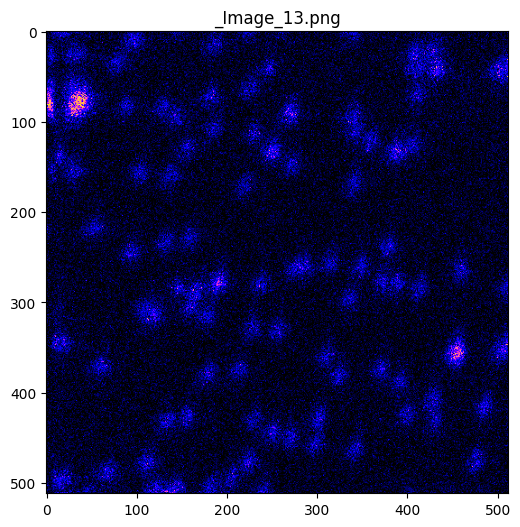

In [53]:
# open PNG image plot with matplotlib
fileDir = './4_data/trainning/200nm/'
fileName = '_Image_13.png'



img = Image.open(fileDir + fileName)
print("PIL mode:", img.mode) # mode 屬性會告訴你色彩模式

img = img.convert('L')  # convert to grayscale
print("PIL mode:", img.mode)
img_array = np.array(img)
fig1, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_array, cmap='gnuplot2')
ax.set_title(fileName)
fig1.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3907055257.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


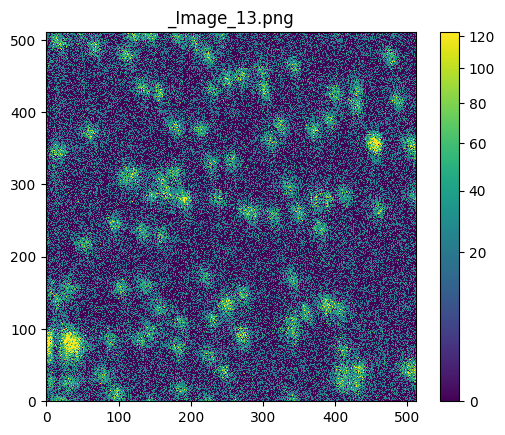

In [54]:
from vidualize import plot_picture

fig, ax = plot_picture(img_array, percent= 99.5)
ax.set_title(fileName)
fig.show()

## Background extract

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/1419233777.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


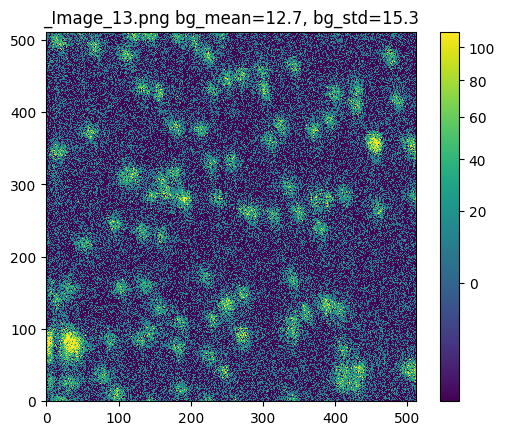

In [55]:
# viw the region that > bg_mean + kappa*std -> source
# let it be a great value to see it
from kapasigmaClip import kappaSigmaClipping

mask, bg_mean, bg_std = kappaSigmaClipping(3, 20, img_array)
image_clean_bg = img_array - bg_mean # remove background mean
fig, ax = plot_picture(image_clean_bg, percent= 99.5)
ax.set_title(fileName + f' bg_mean={bg_mean:.1f}, bg_std={bg_std:.1f}')
fig.show()


## Find source

In [56]:
from findSource import find_source, plot_source

sources = find_source(image_clean_bg, sigma=6, fwhm=12.0, threshold_times=2.5)
print(f"Found {len(sources)} sources")

Found 54 sources


## Plot source hold radius

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/2723434240.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


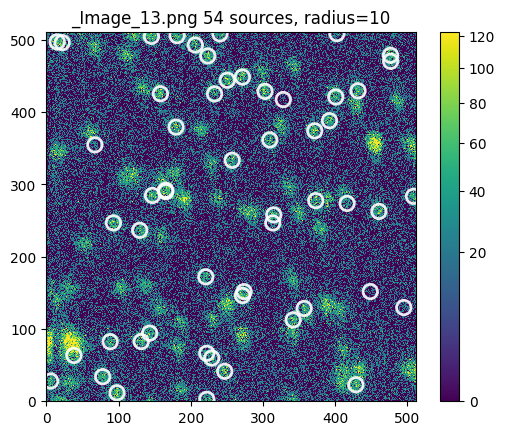

In [57]:
radius = 10
fig, ax = plot_source(img_array, sources, radius=radius, percent=99.5)
ax.set_title(f'{fileName} {len(sources)} sources, radius={radius}') 
fig.show()

## FWHM 2D fitting
Use a fix size square area (ex: 12 * 12 pixels) to fit 2D gaussian, 
the sixe of square nedd to guess based on image.

astropy.modeling models Gaussian2D
since we don't know fwhm, the fitting iteration is high, in this case = 10000

In [58]:
from fwhm2d import FWHM2d


fwhm_x_list, fwhm_y_list, mask = FWHM2d(sources, img_array, sub_size_half=9)
sources['x_fwhm'] = fwhm_x_list
sources['y_fwhm'] = fwhm_y_list
sources = sources[mask]  # only keep the sources with valid FWHM


dict_keys(['nfev', 'fvec', 'fjac', 'ipvt', 'qtf', 'message', 'ierr', 'param_jac', 'param_cov', 'njev', 'cov_x'])
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
1


Text(0.5, 1.0, '_Image_13.png with FWHM elipse')

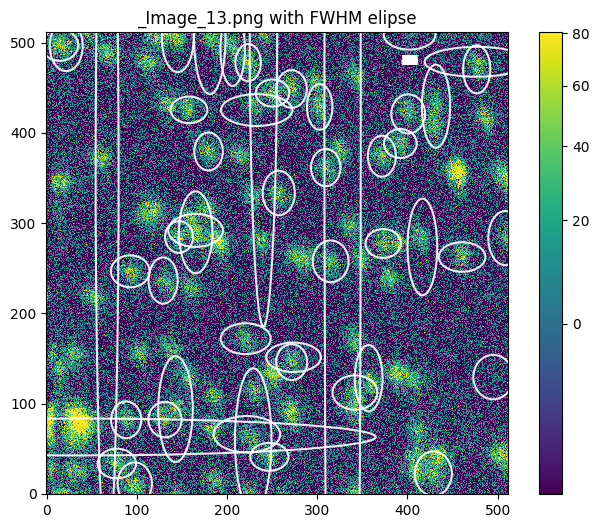

In [59]:
from fwhm2d import plot_source_fwhm_ellips

fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')

## Clean source with strange FWHM

### Plot FWHM distribution

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/675293388.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


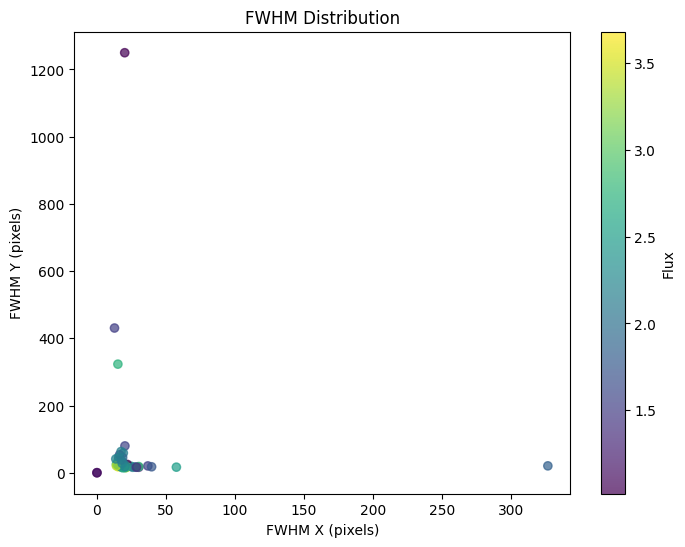

In [60]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm'], sources['y_fwhm'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

### delete FWHM > threshhold sources

Cleaned sources: 20


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/706331923.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


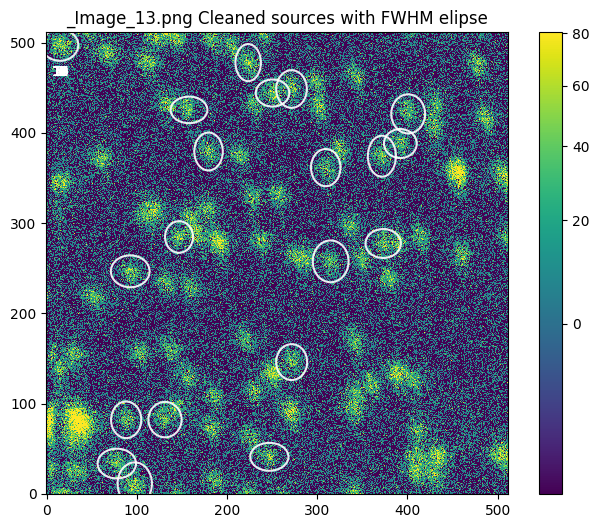

In [61]:
fwhm_threshhold_high = 24
fwhm_threshhold_low = 5
flux_threshhold_high = 100
mask = (
    (sources['x_fwhm'] < fwhm_threshhold_high) &
    (sources['y_fwhm'] < fwhm_threshhold_high) &
    (sources['x_fwhm'] > fwhm_threshhold_low) &
    (sources['y_fwhm'] > fwhm_threshhold_low) &
    (sources['flux'] < flux_threshhold_high)
)
source_cleaned = sources[mask]
print(f"Cleaned sources: {len(source_cleaned)}")
fig, ax = plot_source_fwhm_ellips(image_clean_bg, source_cleaned, figsize=(8, 6))
ax.set_title(f'{fileName} Cleaned sources with FWHM elipse')
fig.show()



## FWHMx y 1D fitting
Use FWHM 2D fitting result as initioal fitting parm fit again
not sure is this is necessary, but for plot 1D fitting convenience, just fit again...

### X

In [62]:
from fwhm1d import fit_gaussian_xy_new, plot_fit_gaussian_and_data
rms_x_list = []
num_sources = len(sources)
axis = 'x'
avg_pixel_num = 6
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )
    rms_x_list.append(rms)

sources['rms_fit_x'] = rms_x_list

sources = sources[np.isfinite(sources['rms_fit_x'])].copy()



### Y

In [63]:
from fwhm1d import fit_gaussian_xy_new, plot_fit_gaussian_and_data
rms_y_list = []
num_sources = len(sources)
axis = 'y'
avg_pixel_num = 6
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )
    rms_y_list.append(rms)

sources['rms_fit_y'] = rms_y_list


sources = sources[np.isfinite(sources['rms_fit_y'])].copy()



In [64]:
# # plot
# num_sources = len(sources)
# max_plot_num = 5
# axis = 'y'
# num_cols = 5
# num_rows = (min(max_plot_num, num_sources) + num_cols - 1) // num_cols
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))
# axes = axes.flatten()  # 將 2D 陣列展平為 1D 陣列
# for i in range(min(max_plot_num, num_sources)):
#     parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
#         image_clean_bg, sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
#     )    
#     fig, ax = plot_fit_gaussian_and_data(
#         parm=parm, x_rel=main_rel_range,
#         intensity_profile=intensity_profile, ax=axes[i]
#     )
#     amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
#     fwhm_fit = sigma * 2.355
#     ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3205519490.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


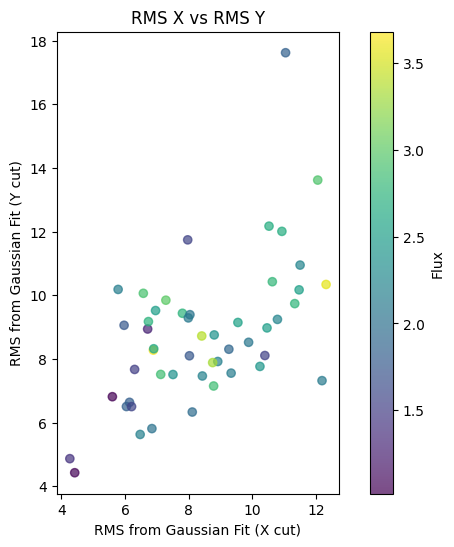

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['rms_fit_x'], sources['rms_fit_y'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('RMS from Gaussian Fit (X cut)')
ax.set_ylabel('RMS from Gaussian Fit (Y cut)')
ax.set_title('RMS X vs RMS Y')
# let x y scale same
ax.set_aspect('equal', 'box')

fig.show()

### Clean again

Cleaned sources: 31


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/1168304459.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


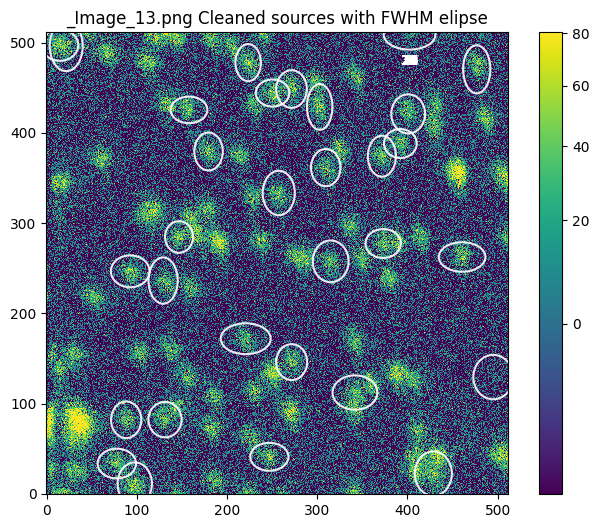

In [66]:
fwhm_threshhold_high = 30
fwhm_threshhold_low = 1
flux_threshhold_high = 200
flux_threshhold_low = 1
mask = (
    (sources['x_fwhm'] < fwhm_threshhold_high) &
    (sources['y_fwhm'] < fwhm_threshhold_high) &
    (sources['x_fwhm'] > fwhm_threshhold_low) &
    (sources['y_fwhm'] > fwhm_threshhold_low) &
    (sources['flux'] < flux_threshhold_high) & 
    (sources['flux'] > flux_threshhold_low)
)
sources = sources[mask]
print(f"Cleaned sources: {len(sources)}")
fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
ax.set_title(f'{fileName} Cleaned sources with FWHM elipse')
fig.show()



/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/313886698.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


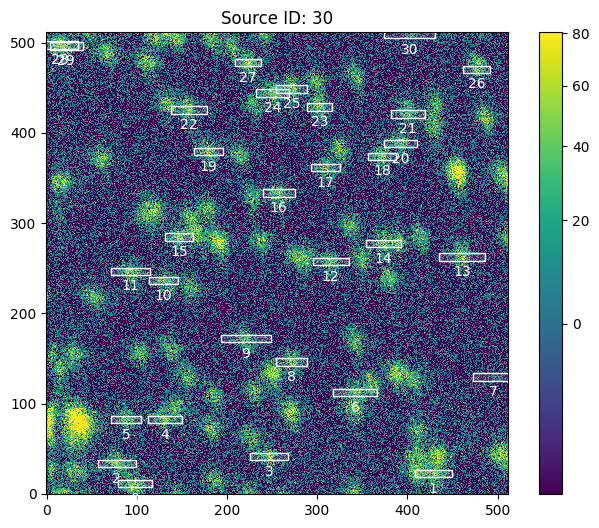

In [67]:
import matplotlib.patches as patches

source_id = 1
fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(sources)):
    source_id = i
    x0, y0, x_half_range, y_half_range = sources[source_id]['xcentroid'], sources[source_id]['ycentroid'], sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.set_title('Source ID: {}'.format(source_id))
    fig1.show()

## FWHM calculation

### FOV by measure

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/871116255.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


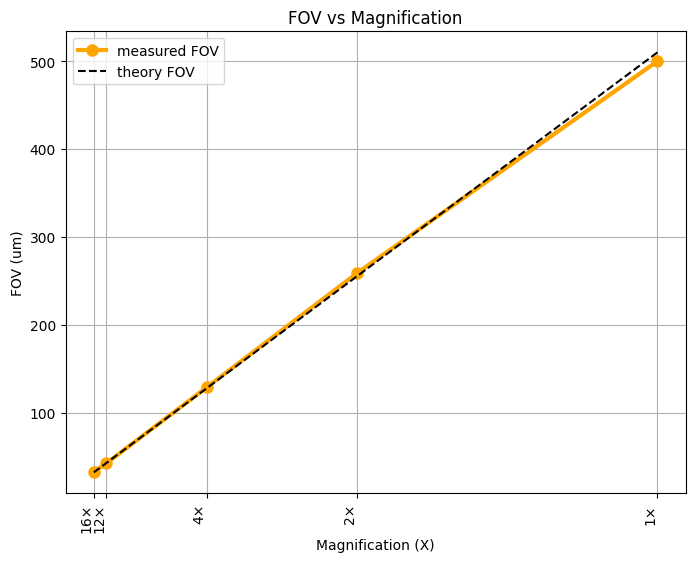

In [68]:
import matplotlib.pyplot as plt
import numpy as np

fov_mag = np.array([1, 2, 4, 12, 16])
fov_pixel_per_mm = np.array([1024, 1980.5, 3984, 12141, 15808])

fov_arr = 512 / fov_pixel_per_mm

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(1/fov_mag, fov_arr * 1000, marker='o', linestyle='-', 
        label='measured FOV', color ='orange', markersize=8, linewidth=3)

fov_theory_arr = 510 / fov_mag
ax.plot(1/fov_mag, fov_theory_arr, marker='', linestyle='--', label='theory FOV', color='black')
# set x label to mag
plt.xticks(1/fov_mag, [str(m) + '×' for m in fov_mag])
plt.setp(plt.gca().get_xticklabels(), rotation=90, ha='right')


ax.set_xlabel('Magnification (X)')
ax.set_ylabel('FOV (um)')
ax.set_title('FOV vs Magnification')
ax.grid(True)
ax.legend()
fig.show()

### FOV by calculation

In [69]:
# lens FOV calculation
FN = 26.5 # field num, mm
Mag = 20 # magnification
FOV_lens = FN / Mag # um

print(f"lens FOV from lens: {FOV_lens:.2f} mm")

lens FOV from lens: 1.32 mm


In [70]:
# galvo fov calculation
Galvo_angle = 6.5
galvo_angle_rad = np.deg2rad(Galvo_angle)
f_sl = 50 # mm
f_tl = 200 # mm
f_obj = 9 # mm

four_f_system_mag = np.arctan(np.tan(galvo_angle_rad) * f_sl / f_tl) / galvo_angle_rad
four_f_system_mag_near = f_sl / f_tl
FOV_galvo_theory = 2*np.tan(galvo_angle_rad * four_f_system_mag) * f_obj * 1000 # um
print(f"theory FOV from galvo: {FOV_galvo_theory:.2f} um")

FOV_galvo_approx = 2*np.tan(galvo_angle_rad * four_f_system_mag_near) * f_obj * 1000 # um
print(f"approx FOV from galvo: {FOV_galvo_approx:.2f} um")


theory FOV from galvo: 512.71 um
approx FOV from galvo: 510.65 um


### NA and 1/e radii calculation

In [71]:
n = 1
f_obj = 9 # mm
D = 6.3 # mm
NA = n * np.sin(np.arctan(D/(2*f_obj)))
print(f"NA: {NA:.4f}")

NA: 0.3304


In [72]:
landa = 920 # nm
omega_xy = 0.320 * landa / (NA * np.sqrt(2))
print(f"1/e radii omega_zy: {omega_xy:.4f} nm")

omega_z = 0.532 * landa / (np.sqrt(2)) * 1/(n-np.sqrt(n**2 - NA**2))
print(f"1/e radii omega_z: {omega_z:.4f} nm")

1/e radii omega_zy: 630.1558 nm
1/e radii omega_z: 6164.5210 nm


### theory fwhm calculation

In [73]:
fwhm_xy = omega_xy * 2 * np.sqrt(np.log(2))
print(f"theory FWHM xy: {fwhm_xy:.4f} nm")
fwhm_z = omega_z * 2 * np.sqrt(np.log(2))
print(f"theory FWHM z: {fwhm_z:.4f} nm")

theory FWHM xy: 1049.2782 nm
theory FWHM z: 10264.6008 nm


In [74]:
# mag = 12, 12141 pixel/mm
mag = 12
img_dim = 512
pixel_len = FOV_galvo_theory/(mag * img_dim) 
print(f"Pixel size: {pixel_len:.2f} um")
fwhm_x_mean = np.average(sources['x_fwhm'])*pixel_len # um
fwhm_y_mean = np.average(sources['y_fwhm'])*pixel_len # um
fwhm_x_std = np.std(sources['x_fwhm'])*pixel_len # um
fwhm_y_std = np.std(sources['y_fwhm'])*pixel_len # um
print(f"Average FWHM X: {fwhm_x_mean:.4f} um ± {fwhm_x_std:.4f} um")
print(f"Average FWHM Y: {fwhm_y_mean:.4f} um ± {fwhm_y_std:.4f} um")



Pixel size: 0.08 um
Average FWHM X: 1.6047 um ± 0.3031 um
Average FWHM Y: 1.6927 um ± 0.3127 um


## Violin plot of FWHM x y 1D fit

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/2915603575.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM X', 'FWHM Y'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/2915603575.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(0.596078431372549, 0.4486274509803921, 0.2650980392156862)
(0.44392156862745114, 0.5309803921568628, 0.5599999999999999)


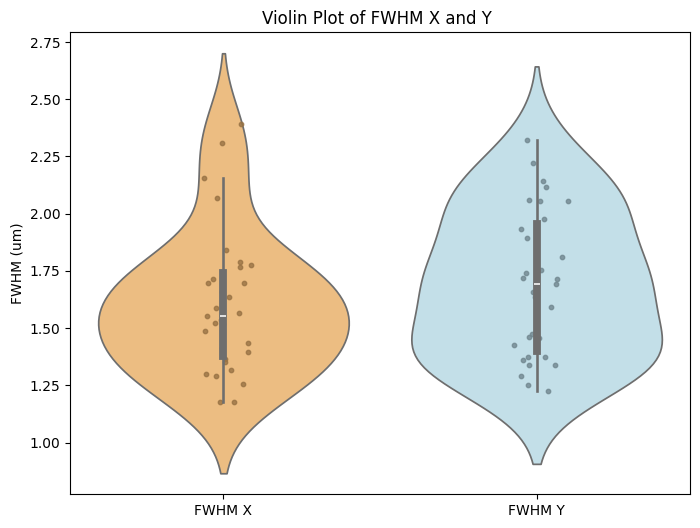

In [75]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')

pixel_len = FOV_galvo_theory/(Mag*img_dim) # um

for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    print(dark_color)
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)

ax.set_title('Violin Plot of FWHM X and Y ')
fig.show()

## Final Source! 

In [76]:
# select mean(fwhm) +- factor*std => let meam +- > factor*std be outlier
factor = 2
fwhm_x_mean = np.mean(sources['x_fwhm'])
fwhm_x_std = np.std(sources['x_fwhm'])
fwhm_y_mean = np.mean(sources['y_fwhm'])
fwhm_y_std = np.std(sources['y_fwhm'])

mask_x = (sources['x_fwhm'] > (fwhm_x_mean - factor*fwhm_x_std)) & (sources['x_fwhm'] < (fwhm_x_mean + factor*fwhm_x_std))
mask_y = (sources['y_fwhm'] > (fwhm_y_mean - factor*fwhm_y_std)) & (sources['y_fwhm'] < (fwhm_y_mean + factor*fwhm_y_std))
mask = mask_x & mask_y
sources = sources[mask]

final_sources = sources


### elipse image plot

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3271009537.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


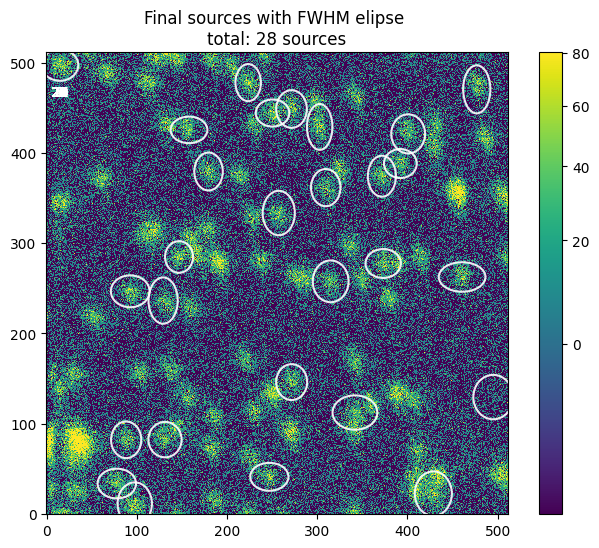

In [77]:
fig, ax = plot_source_fwhm_ellips(image_clean_bg, final_sources, figsize=(8, 6))
ax.set_title(f'Final sources with FWHM elipse \ntotal: {len(final_sources)} sources')
fig.show()

### sample rectangle

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/503631829.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


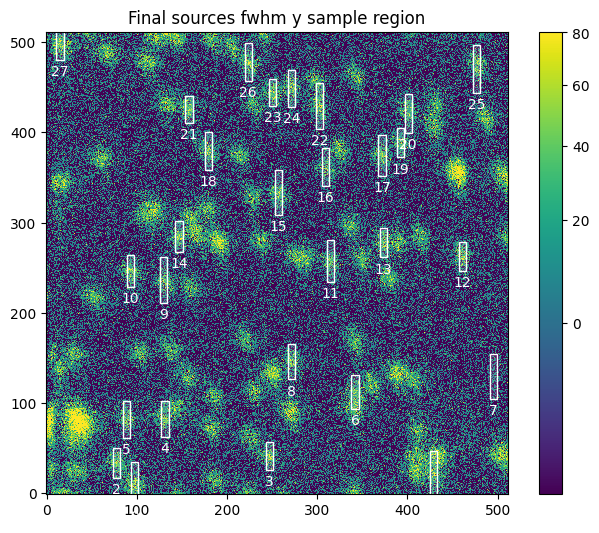

In [78]:
import matplotlib.patches as patches

fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(final_sources)):
    source_id = i
    # x fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], final_sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # y fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], avg_pixel_num//2+1, final_sources[source_id]['y_fwhm']
    rect2 = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    # ax.add_patch(rect)
    ax.add_patch(rect2)
    ax.set_title("Final sources fwhm y sample region")
    fig1.show()

### single sample x

In [79]:
# plot source 1
sourceID = 1
axis = 'x'
avg_pixel_num = 6

parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=sourceID, axis=axis, avg_pixel_num=avg_pixel_num
    )
fig, ax = plot_fit_gaussian_and_data(
        parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile
    )
amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
ax.set_title(f" Source {sourceID}, $FWHM_{axis}$={fwhm_fit:.2f}, rms={rms:.2f}")
fig.show()



/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/1694007036.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


ValueError: Image size of 523x110202 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x400 with 1 Axes>

### single sample Y

In [80]:
# plot source 1
sourceID = 1
axis = 'y'
avg_pixel_num = 6

parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, sources, sourceID=sourceID, axis=axis, avg_pixel_num=avg_pixel_num
    )
fig, ax = plot_fit_gaussian_and_data(
        parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile
    )
amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
ax.set_title(f" Source {sourceID}, $FWHM_{axis}$={fwhm_fit:.2f}, rms={rms:.2f}")
fig.show()



/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/2782029020.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


ValueError: Image size of 512x97835 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x400 with 1 Axes>

In [81]:
# plot
num_sources = len(final_sources)
max_plot_num = 10
axis = 'x'
num_cols = 5
num_rows = (min(max_plot_num, num_sources) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
axes = axes.flatten()  # 將 2D 陣列展平為 1D 陣列
for i in range(min(max_plot_num, num_sources)):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy_new(
        image_clean_bg, final_sources, sourceID=i, axis=axis, avg_pixel_num=avg_pixel_num
    )    
    fig, ax = plot_fit_gaussian_and_data(
        parm=parm, x_rel=main_rel_range,
        intensity_profile=intensity_profile, ax=axes[i]
    )
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")

ValueError: Image size of 2004x125222 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2500x1000 with 10 Axes>

In [82]:
max(sources['x_fwhm'])

25.854462941816486

### Violin plot

Cleaned FWHM X: 0.93 +- 0.15 um
Cleaned FWHM Y: 1.01 +- 0.18 um


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3790078381.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM X', 'FWHM Y'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3790078381.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


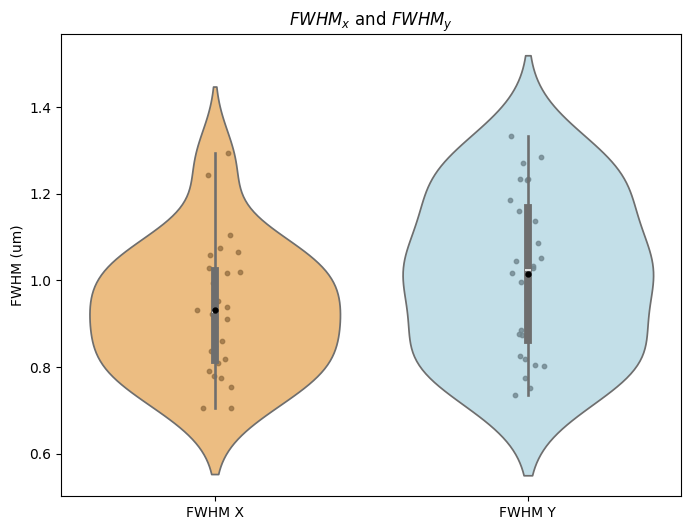

In [83]:
# violin plot of FWHM x y 1D fit, plot all sources as dot
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('RdYlBu', n_colors=2)
data = [sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM X', 'FWHM Y'])
ax.set_ylabel('FWHM (um)')
# calculate mean and std
mean_y_fwhm_pixel = np.mean(sources['y_fwhm']*pixel_len)
mean_x_fwhm_pixel = np.mean(sources['x_fwhm']*pixel_len)
std_y_fwhm_pixel = np.std(sources['y_fwhm']*pixel_len)
std_x_fwhm_pixel = np.std(sources['x_fwhm']*pixel_len)
print(f"Cleaned FWHM X: {mean_x_fwhm_pixel:.2f} +- {std_x_fwhm_pixel:.2f} um")
print(f"Cleaned FWHM Y: {mean_y_fwhm_pixel:.2f} +- {std_y_fwhm_pixel:.2f} um")
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)
for i in range(len(data)):
    mean_val = np.mean(data[i])
    ax.scatter(i, mean_val, color='black', s=50, marker='.', zorder=10, label='Mean' if i == 0 else "")

ax.set_title(f'$FWHM_x$ and $FWHM_y$')
fig.show()

In [84]:
FOV = 510.6 # um <- theory FOV
Mag = 12
img_dim = 512
pixel_len = FOV/(Mag*img_dim) # um
print(f"Pixel size: {pixel_len:.2f} um") 
fwhm_x = np.average(sources['x_fwhm'])*pixel_len # um
fwhm_y = np.average(sources['y_fwhm'])*pixel_len #
print(f"Average FWHM X: {fwhm_x:.4f} um, {np.average(sources['x_fwhm'])} pixels")
print(f"Average FWHM Y: {fwhm_y:.4f} um, {np.average(sources['y_fwhm'])} pixels")

Pixel size: 0.08 um
Average FWHM X: 1.5479 um, 18.625591225184376 pixels
Average FWHM Y: 1.6841 um, 20.26425830263442 pixels


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3736678162.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


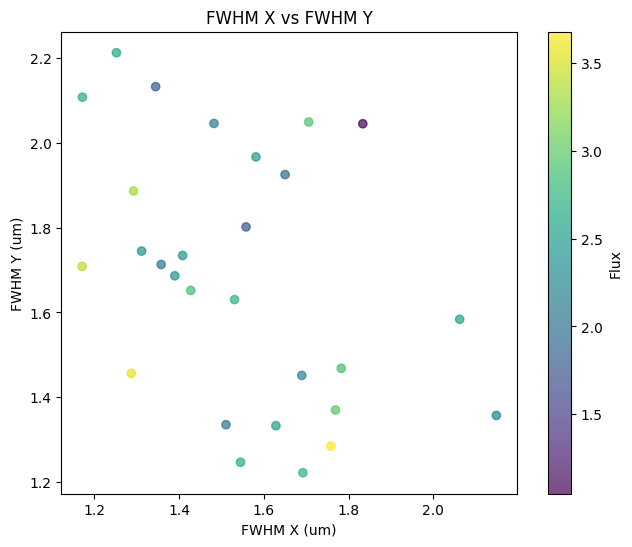

In [85]:
# plot fwhm x y scatter
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm']*pixel_len, sources['y_fwhm']*pixel_len, c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (um)')
ax.set_ylabel('FWHM Y (um)')
ax.set_title('FWHM X vs FWHM Y')
# let x y scale same
ax.set_aspect('equal', 'box')
fig.show()

## FWHM z fit

In [86]:
# in specified folder, read add PNG. Select source by above analysis, 
# for each image, select x0 y0 加上外面一圈九宮格，average as intensity profile
# then fit gaussian to get FWHM z
# the image distance is known, 0.5 um step, 12 images, total 6 um z range

fileDir = './4_data/trainning/200nm/'

# read all PNG files in the folder
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

file_list = [f for f in os.listdir(fileDir) if f.endswith('.png')]
# name exapple: _Image_10.png
# sort by the number in the name
file_list = sorted(file_list, key=lambda x: int(x.split('_Image_')[1].split('.png')[0]))
print(f"Found {len(file_list)} PNG files")
print(file_list)


Found 25 PNG files
['_Image_1.png', '_Image_2.png', '_Image_3.png', '_Image_4.png', '_Image_5.png', '_Image_6.png', '_Image_7.png', '_Image_8.png', '_Image_9.png', '_Image_10.png', '_Image_11.png', '_Image_12.png', '_Image_13.png', '_Image_14.png', '_Image_15.png', '_Image_16.png', '_Image_17.png', '_Image_18.png', '_Image_19.png', '_Image_20.png', '_Image_21.png', '_Image_22.png', '_Image_23.png', '_Image_24.png', '_Image_25.png']


In [87]:
# average intensity profile for each source
num_sources = len(final_sources)
num_images = len(file_list)
z_step = 0.5 # um
z_positions = np.arange(0, num_images * z_step, z_step) # um
print(f"Z positions: {z_positions}")



Z positions: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12. ]


### average a square as a source samle in one image

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/4217840719.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


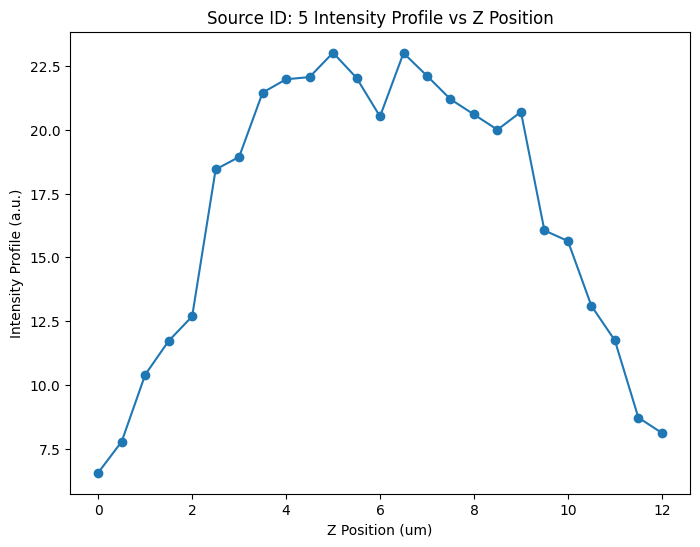

In [96]:
source_profiles_all = []
pix_num = 15
for source_id in range(num_sources):
    intensity_profiles = []
    for file_name in file_list:
        img = Image.open(os.path.join(fileDir, file_name))
        img = img.convert('L')  # convert to grayscale
        img_array = np.array(img)
        x0 = int(final_sources[source_id]['xcentroid'])
        y0 = int(final_sources[source_id]['ycentroid'])
        # plot source position
        # fig, ax = plot_picture(img_array, percent= 99.5)
        # ax.plot(x0, y0, 'w+', markersize=15)
        # ax.set_title(f'Source ID: {source_id} in {file_name}')
        # fig.show()
        # extract 3x3 region
        y_low_bound = max(0, y0-pix_num)
        y_up_bound = min(img_array.shape[0], y0+pix_num)
        x_low_bound = max(0, x0-pix_num)
        x_up_bound = min(img_array.shape[1], x0+pix_num) 
        region = img_array[y_low_bound:y_up_bound, x_low_bound:x_up_bound]
    #     # plot region
    #     fig, ax = plt.subplots(figsize=(4, 4))
    #     ax.imshow(region, cmap='gnuplot2', vmin=0, vmax=255)
    #     ax.set_title(f'Source ID: {source_id} Region in {file_name}')
    #     fig.show()
    #     # average intensity profile
        intensity_profile = np.mean(region)
        intensity_profiles.append(intensity_profile)
    intensity_profiles = np.array(intensity_profiles)
    source_profiles_all.append(intensity_profiles)
    
    # plot intensity profile vs z position
source_id = 5
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(z_positions, source_profiles_all[source_id], marker='o', linestyle='-')
ax.set_xlabel('Z Position (um)')
ax.set_ylabel('Intensity Profile (a.u.)')
ax.set_title(f'Source ID: {source_id} Intensity Profile vs Z Position')
fig.show()

### fig gaussian

In [93]:
# fit intensity profile to gaussian to get FWHM z 
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) + offset

fwhm_z_list = []
fwhm_fit_parm_list = []
for source_id in range(num_sources):
    intensity_profiles = source_profiles_all[source_id]

    if intensity_profiles.size == 0 or np.allclose(intensity_profiles, intensity_profiles[0]):
        # If the profile is empty or constant, skip fitting
        fwhm_z_list.append(np.nan)
        fwhm_fit_parm_list.append([np.nan, np.nan, np.nan, np.nan])
        continue

    peak_idx = int(np.argmax(intensity_profiles))
    amp0 = float(np.max(intensity_profiles) - np.min(intensity_profiles))
    mu0 = float(z_positions[peak_idx])
    sigma0 = 1.0
    offset0 = float(np.min(intensity_profiles))
    p0 = [amp0, mu0, sigma0, offset0]

    try:
        popt, pcov = curve_fit(gaussian, z_positions, intensity_profiles, p0=p0, maxfev=5000)
        amp, mu, sigma, offset = popt
        fwhm_z = 2.355 * sigma  # FWHM = 2.355 * sigma
        fwhm_fit_parm_list.append(popt.tolist())
    except (RuntimeError, ValueError):
        fwhm_z = np.nan
        fwhm_fit_parm_list.append([np.nan, np.nan, np.nan, np.nan])

    fwhm_z_list.append(fwhm_z)


In [94]:
final_sources['fwhm_z'] = fwhm_z_list
final_sources['fwhm_fit_parm'] = fwhm_fit_parm_list
# clean nan fwhm_z
final_sources = final_sources[np.isfinite(final_sources['fwhm_z'])].copy()
print(f"Final sources with FWHM z: {len(final_sources)}")



Final sources with FWHM z: 28


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/1025606.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


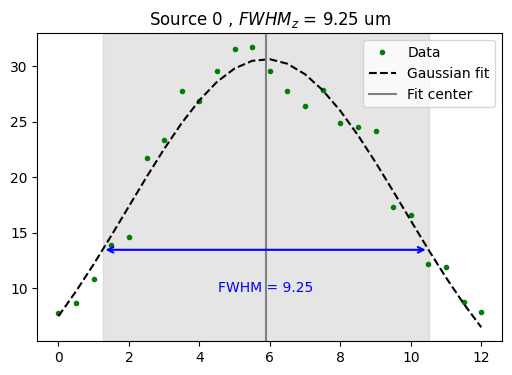

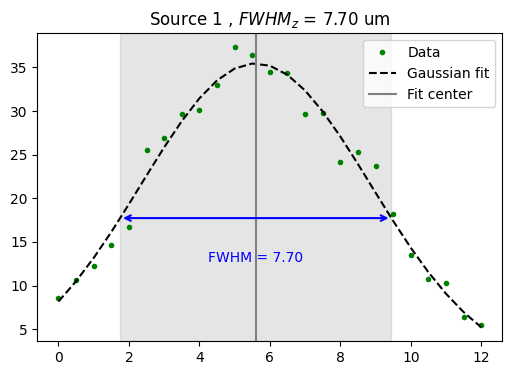

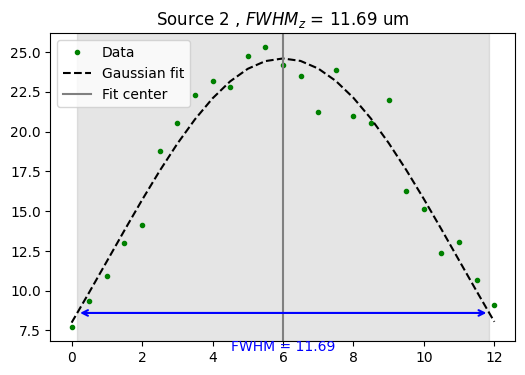

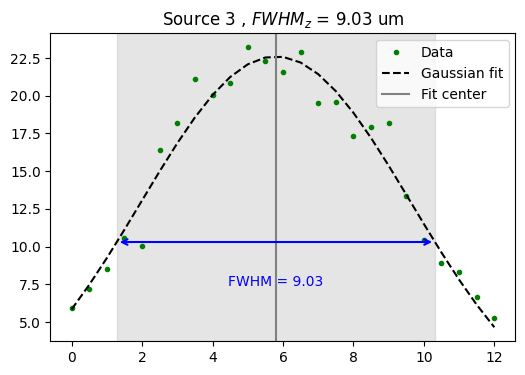

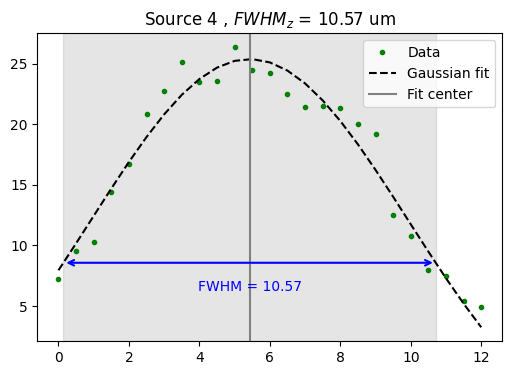

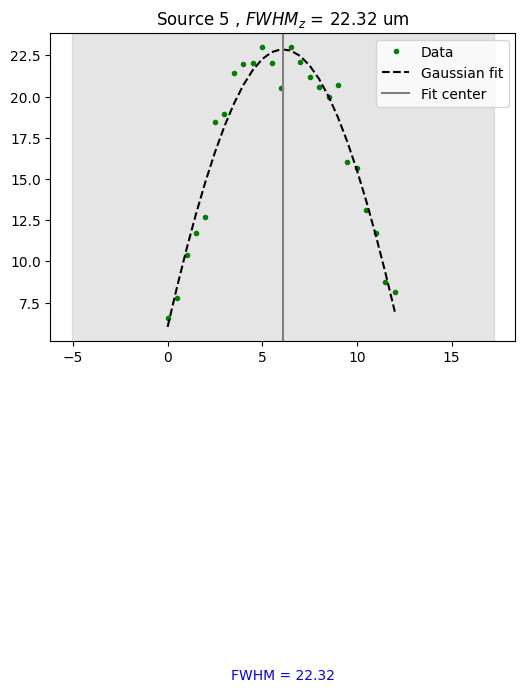

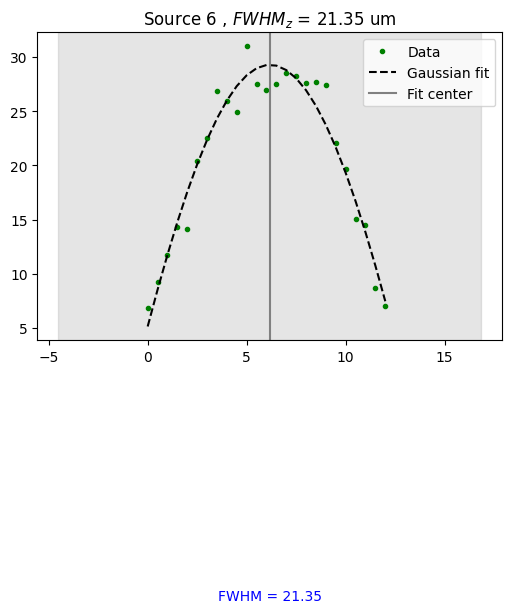

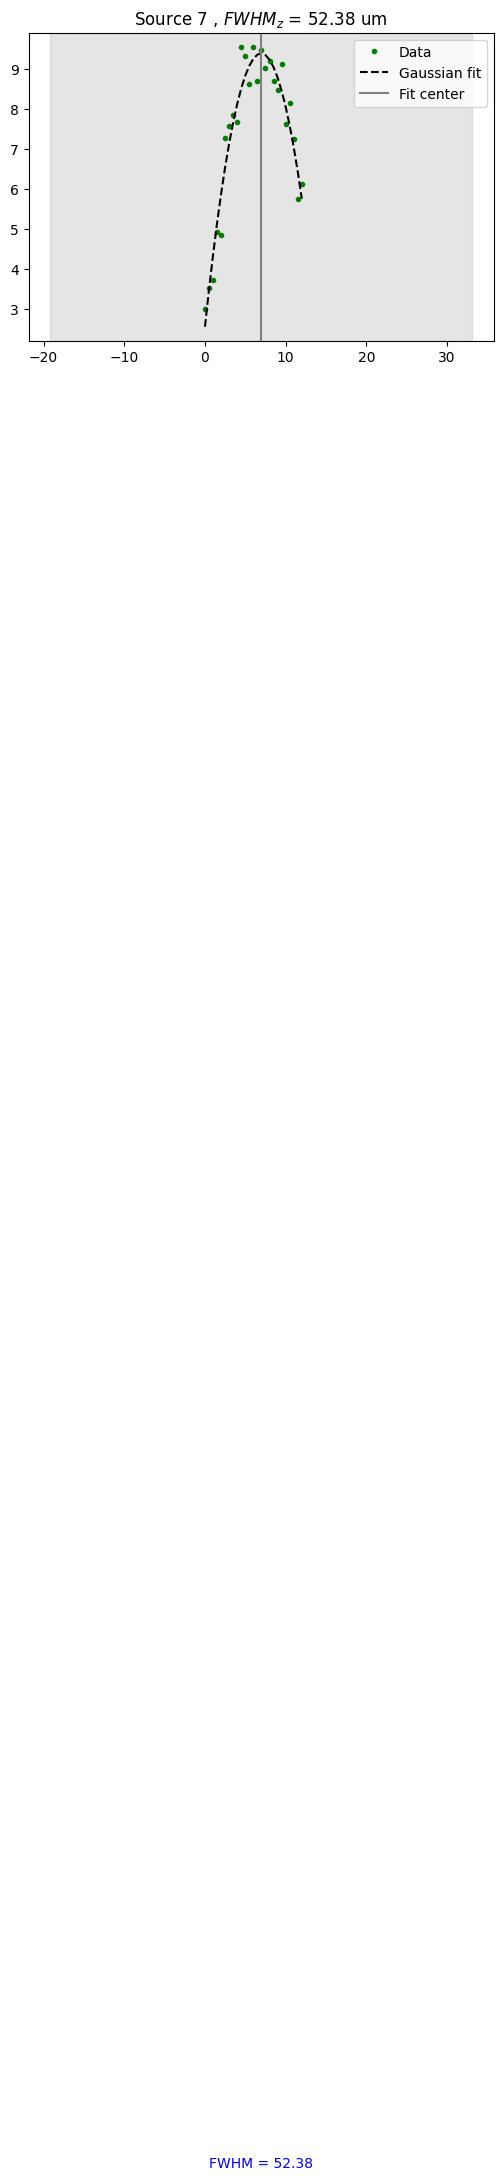

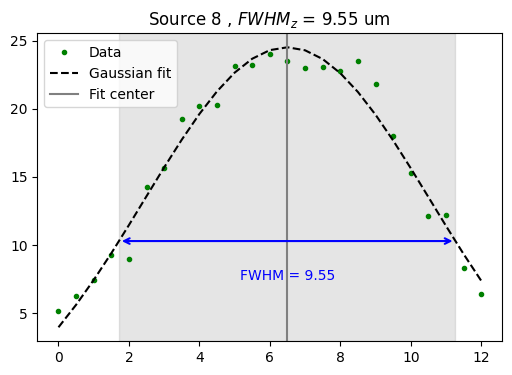

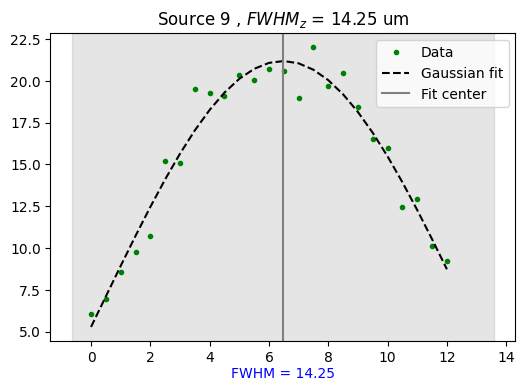

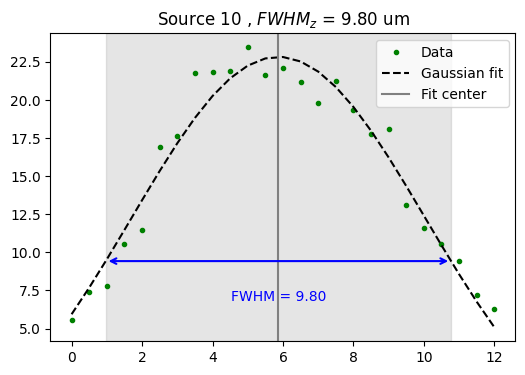

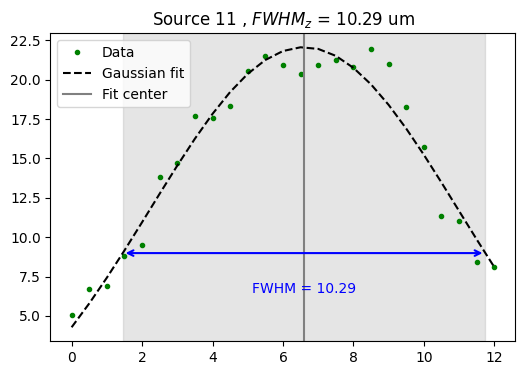

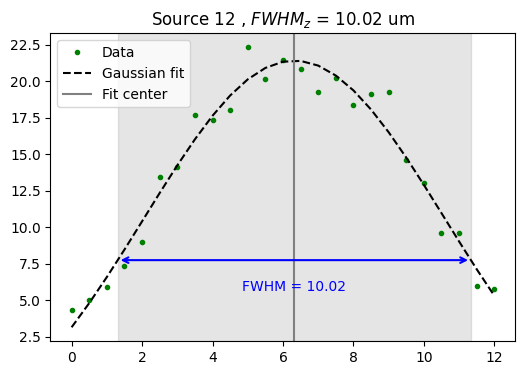

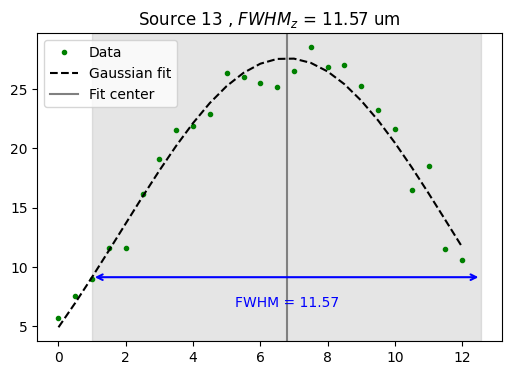

ValueError: Image size of 535x118067 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 600x400 with 1 Axes>

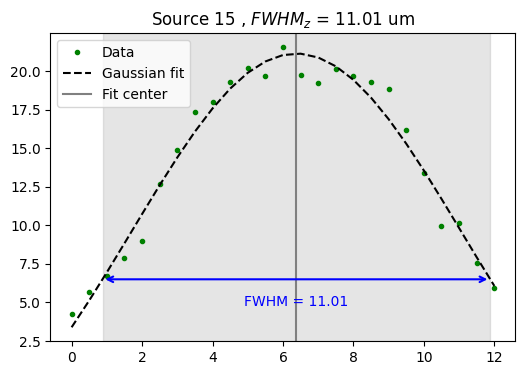

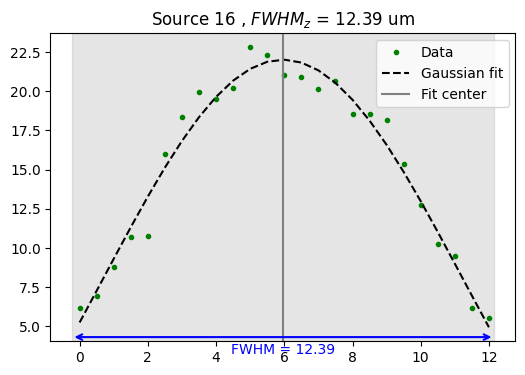

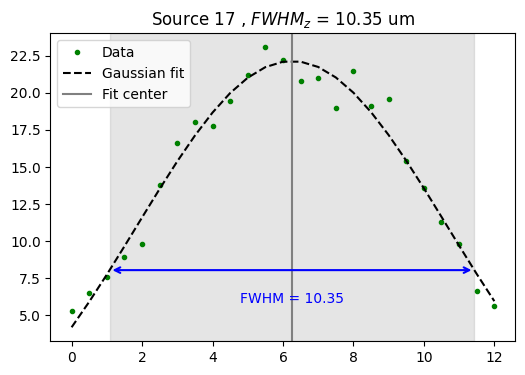

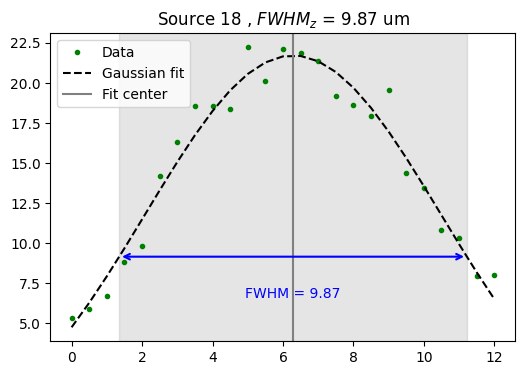

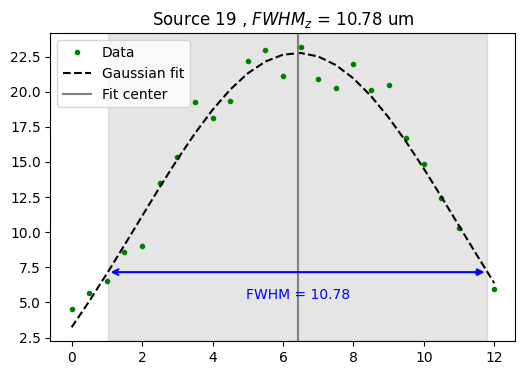

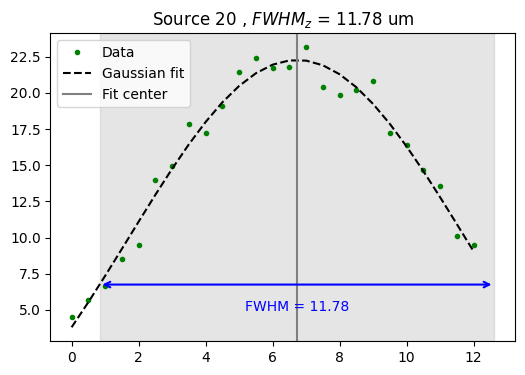

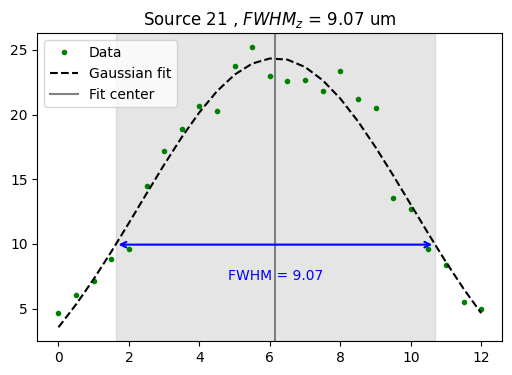

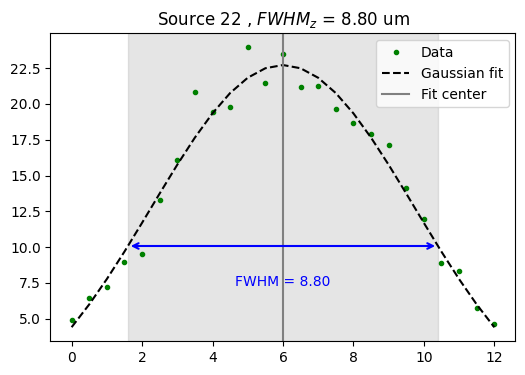

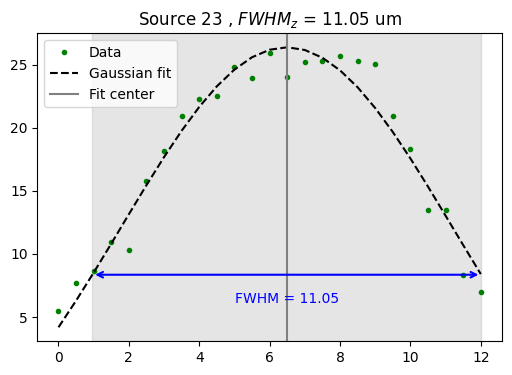

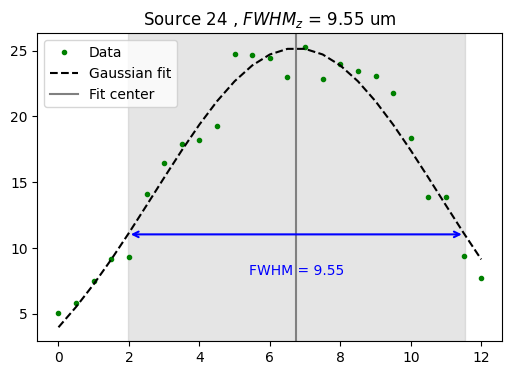

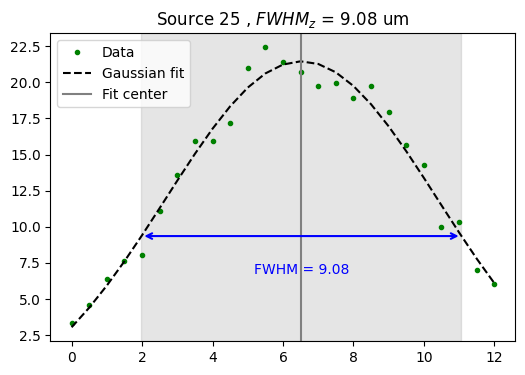

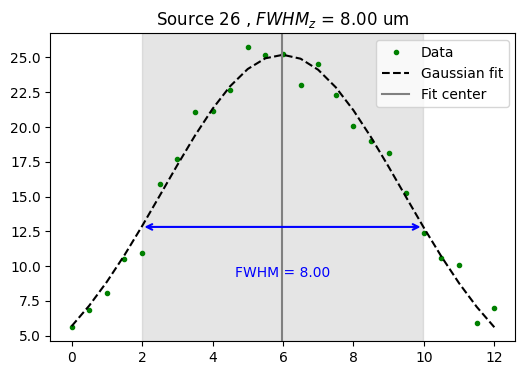

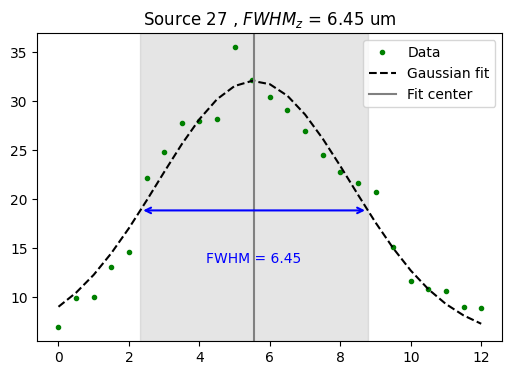

In [98]:
# from fwhm1d import plot_fit_gaussian_and_data
# # plot fit result
for source_id in range(len(final_sources)):
# source_id = 3
    intensity_profile = source_profiles_all[source_id]
    parm = final_sources['fwhm_fit_parm'][source_id]
    fig, ax = plot_fit_gaussian_and_data(parm = parm, x_rel = z_positions, intensity_profile = intensity_profile)
    ax.set_title(f'Source {source_id} , $FWHM_z$ = {final_sources["fwhm_z"][source_id]:.2f} um')
    fig.show()

In [41]:
mean_z_fwhm = np.mean(final_sources['fwhm_z'])
mean_z_fwhm
std_z_fwhm = np.std(final_sources['fwhm_z'])
std_z_fwhm
# elliminate outlier by mean +- 2*std
factor = 1.8
mask_z = (final_sources['fwhm_z'] > (mean_z_fwhm - factor*std_z_fwhm)) & (final_sources['fwhm_z'] < (mean_z_fwhm + factor*std_z_fwhm))
final_sources = final_sources[mask_z]
print(f"Final sources after FWHM z cleaning: {len(final_sources)}")
mean_z_fwhm = np.mean(final_sources['fwhm_z'])
std_z_fwhm = np.std(final_sources['fwhm_z'])
print(f"Final FWHM z: {mean_z_fwhm:.2f} +- {std_z_fwhm:.2f} um")


Final sources after FWHM z cleaning: 27
Final FWHM z: 12.52 +- 8.54 um


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/2923868479.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FWHM Z'])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/2923868479.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Cleaned FWHM Z: 12.52 +- 8.54 um


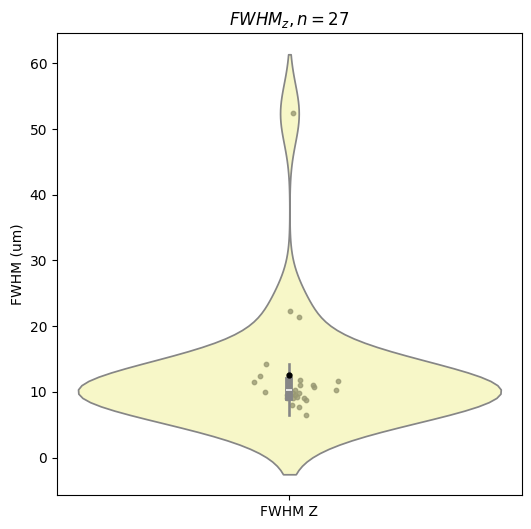

In [42]:
# violin plot of FWHM z
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 6))
palette = sns.color_palette('RdYlBu', n_colors=1)
data = [final_sources['fwhm_z']]
ax = sns.violinplot(data=data, palette=palette)
ax.set_xticklabels(['FWHM Z'])
ax.set_ylabel('FWHM (um)')
# calculate mean and std
mean_y_fwhm_pixel = np.mean(final_sources['fwhm_z'])
std_y_fwhm_pixel = np.std(final_sources['fwhm_z'])
print(f"Cleaned FWHM Z: {mean_y_fwhm_pixel:.2f} +- {std_y_fwhm_pixel:.2f} um")
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i, 0.04, size=len(y))  # 添加一些隨機噪聲以避免重疊
 # 取得小提琴顏色，調深一點（這裡用更低亮度）
    base_color = palette[i]
    dark_color = tuple([c * 0.6 for c in base_color])  # 0.7 可再調整ax.set_title('Violin Plot of FWHM X and Y ')
    ax.scatter(x, y, color=dark_color, alpha=0.8, s=10)
for i in range(len(data)):
    mean_val = np.mean(data[i])
    ax.scatter(i, mean_val, color='black', s=50, marker='.', zorder=10, label='Mean' if i == 0 else "")
ax.set_title(f'$FWHM_z, n = {len(final_sources)}$')
fig.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3870166171.py:2: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/3870166171.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


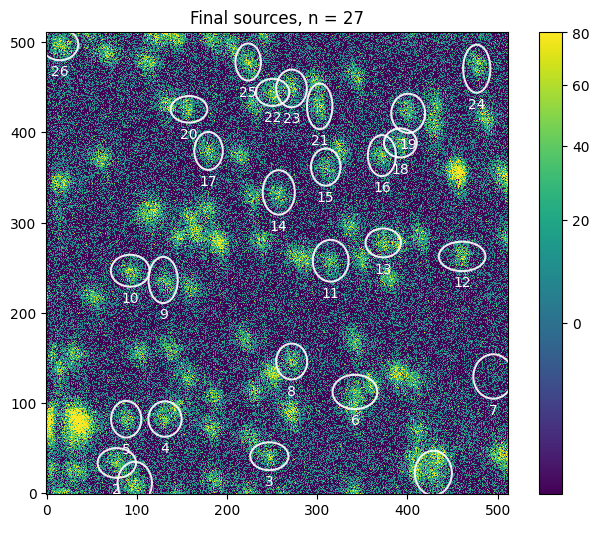

In [43]:
import matplotlib.patches as patches
from photutils import EllipticalAperture
fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(final_sources)):
    source_id = i
    # x fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], final_sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 0.5), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # y fwhm rectangle
    x0, y0, x_half_range, y_half_range = final_sources[source_id]['xcentroid'], final_sources[source_id]['ycentroid'], avg_pixel_num//2+1, final_sources[source_id]['y_fwhm']
    rect2 = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 0.5), # white, alpha
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # draw x y as a b ellips
    position = (x0, y0)
    a = final_sources[i]['x_fwhm']  # x軸半徑
    b = final_sources[i]['y_fwhm']  # y軸半徑
    theta = 0  # 橢圓角度（如有可用 source['theta']）
    aperture = EllipticalAperture(position, a=a, b=b, theta=theta)

    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    # ax.add_patch(rect)
    # ax.add_patch(rect2)
    aperture.plot(color='white', lw=1.5, alpha=0.9, ax=ax)
    ax.set_title(f"Final sources, n = {len(final_sources)}")
    fig1.show()



(25, 40)


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/1352587809.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


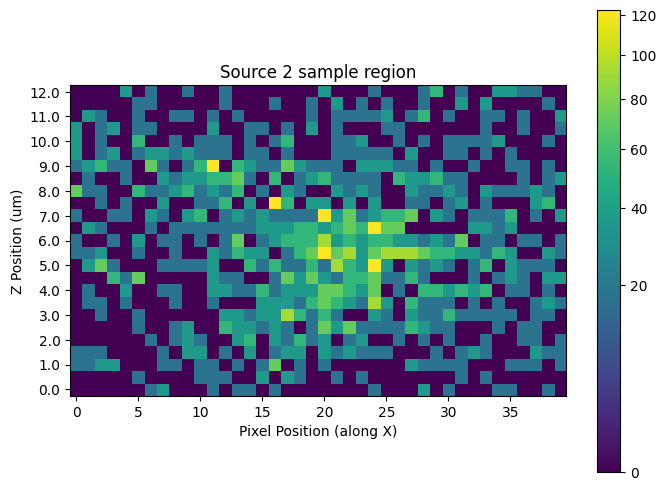

In [104]:
# for a specific source, for each photo, select a row of data along x, 
# then stack all photos to get a 2D array, x axis is pixel position, y axis is z position
# plot image

source_id = 2
intensity_profiles_2d = []
region_len = 20
pix_num = pix_num
x_min = max(0, int(final_sources[source_id]['xcentroid'])-region_len)
x_max = min(img_array.shape[1], int(final_sources[source_id]['xcentroid'])+region_len)
for file_name in file_list:
    img = Image.open(os.path.join(fileDir, file_name))
    img = img.convert('L')  # convert to grayscale
    img_array = np.array(img)
    x0 = int(final_sources[source_id]['xcentroid'])
    y0 = int(final_sources[source_id]['ycentroid'])
    # extract row region
    row_region = img_array[y0, x_min:x_max]
    intensity_profiles_2d.append(row_region)
intensity_profiles_2d = np.array(intensity_profiles_2d)
print(intensity_profiles_2d.shape)  # should be (num_images, region_len*2)

rect2 = patches.Rectangle(
# draw sample region
# all y range, x range is center +- region_len
    (x0 - region_len, 0),  # 左
    2*region_len,  # 寬
    img_array.shape[0],  # 高
    linewidth=1,
    edgecolor=(1, 1, 1, 1), # white, alpha
    facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3

)


fig, ax = plot_picture(intensity_profiles_2d, percent=99.5, figsize=(8, 6))
ax.add_patch(rect2)
ax.set_xlabel('Pixel Position (along X)')
ax.set_ylabel('Z Position (um)')
ax.set_title(f'Source {source_id} sample region')
# set y ticks to z position
ax.set_yticks(np.arange(0, len(z_positions), 2))
ax.set_yticklabels([f"{z:.1f}" for z in z_positions[::2]])
fig.show()


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_1144/4063586947.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


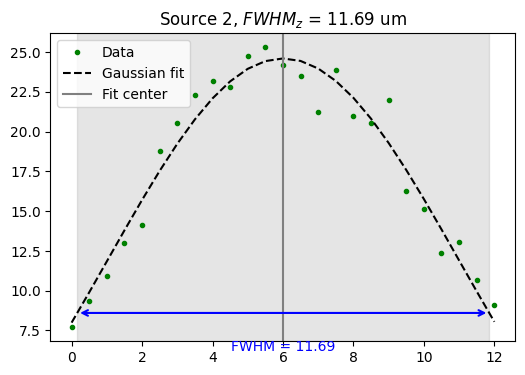

In [102]:
# from fwhm1d import plot_fit_gaussian_and_data
# # plot fit result
# for source_id in range(len(final_sources)):
source_id = 2

intensity_profile = source_profiles_all[source_id]
parm = final_sources['fwhm_fit_parm'][source_id]
fwhm_z = final_sources['fwhm_z'][source_id]
fig, ax = plot_fit_gaussian_and_data(parm = parm, x_rel = z_positions, intensity_profile = intensity_profile)
ax.set_title(f'Source {source_id}, $FWHM_z$ = {fwhm_z:.2f} um')
fig.show()

In [46]:
source_profiles_all

[array([ 7.73076923,  8.60384615, 10.85      , 13.91538462, 14.59615385,
        21.68846154, 23.33076923, 27.74871795, 26.87564103, 29.53076923,
        31.58589744, 31.70769231, 29.6       , 27.80384615, 26.36923077,
        27.86025641, 24.91923077, 24.48974359, 24.16153846, 17.31923077,
        16.57307692, 12.20769231, 11.93076923,  8.76923077,  7.84615385]),
 array([ 8.54      , 10.66333333, 12.28333333, 14.69      , 16.67333333,
        25.47555556, 26.91111111, 29.64555556, 30.15      , 32.93555556,
        37.29111111, 36.42      , 34.48      , 34.30777778, 29.66      ,
        29.72555556, 24.18888889, 25.25888889, 23.68777778, 18.20222222,
        13.48333333, 10.72333333, 10.30333333,  6.46      ,  5.48      ]),
 array([ 7.7       ,  9.38      , 10.94333333, 12.98666667, 14.12666667,
        18.80555556, 20.55666667, 22.32888889, 23.19777778, 22.82777778,
        24.77666667, 25.30777778, 24.21222222, 23.50333333, 21.26555556,
        23.90777778, 20.98333333, 20.57111111, 